In [ ]:
import subprocess
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("AIHUB_API_KEY")
# 1. 설정: Local SSD 내 다운로드 경로
DOWNLOAD_PATH = "data/"
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

# 2. Validation용 파일 키 리스트 (이미지 + 라벨링)
VALID_KEYS = [
    "49602", "49603", "49520", "49521", "49522", "49523", "49524", "49525", "49526", "49527", "49528", "49529", "49530", # 원천(Img)
    "49589", "49590", "49591", "49592", "49593", "49594", "49595", "49596", "49597", "49598", "49599", "49600", "49601"  # 라벨(Json)
]

def run_download():
    for key in VALID_KEYS:
        print(f"📦 파일 키 {key} 다운로드 시도 중...")
        
        # 실행할 명령어 (리스트 형태 권장)
        command = f"aihubshell -mode d -datasetkey 242 -filekey {key} -aihubapikey {api_key}"
        
        try:
            # cwd 인자를 사용하여 해당 경로로 'cd' 한 뒤 명령어를 실행한 효과를 냄
            subprocess.run(command, cwd=DOWNLOAD_PATH, check=True)
            print(f"✅ 파일 키 {key} 완료!")
            
        except subprocess.CalledProcessError as e:
            print(f"❌ 파일 키 {key} 실패: {e}")

if __name__ == "__main__":
    run_download()

In [ ]:
# 압축해제
import zipfile
zip_path = "raw/052.건강관리를_위한_음식_이미지_데이터/01.데이터/2.Validation/원천데이터/음식001_Val.zip"
EXTRACT_DIR = "extracted/"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
	zip_ref.extractall(EXTRACT_DIR)

In [271]:
# 용량확인(zip 파일과 압축 해제된 폴더의 용량 비교, 이미지 프로세싱 전후의 용량 차이 확인)
import os
zip_path = "data/raw/052.건강관리를_위한_음식_이미지_데이터/01.데이터/2.Validation/원천데이터/"
EXTRACT_DIR = "data/extracted/"
SAVE_DIR = "data/processed"

os.makedirs(EXTRACT_DIR, exist_ok=True)
os.makedirs(SAVE_DIR, exist_ok=True)

def get_dir_size(path):
	def _get_bytes(p):
			total = 0
			with os.scandir(p) as it:
				for entry in it:
					if entry.is_file():
						total += entry.stat().st_size
					elif entry.is_dir():
						# 재귀 호출 시에도 Byte를 반환받아 더함
						total += _get_bytes(entry.path)
			return total
	total_bytes = _get_bytes(path)
	return total_bytes / (1024 ** 3)  # GB 단위 변환


print("1chunk 용량 JPG VS webP 비교")
# 처리 전 용량
raw_size = get_dir_size(zip_path)
print(f"원본 폴더 용량: {raw_size:.2f} GB")

# JPG 처리 후 용량
resized_jpg_size = get_dir_size("data/resized_384")
print(f"JPG 리사이징 완료 용량: {resized_jpg_size:.2f} GB")
print(f"📉 용량 감소율: {(1 - resized_jpg_size/raw_size)*100:.1f}%")

# webP 처리 후 용량
resized_webp_size = get_dir_size("data/resized_384_webp")
print(f"webP 리사이징 완료 용량: {resized_webp_size:.2f} GB")
print(f"📉 용량 감소율: {(1 - resized_webp_size/raw_size)*100:.1f}%")

1chunk 용량 JPG VS webP 비교
원본 폴더 용량: 7.43 GB
JPG 리사이징 완료 용량: 1.24 GB
📉 용량 감소율: 83.3%
webP 리사이징 완료 용량: 0.69 GB
📉 용량 감소율: 90.8%


In [ ]:
# 처리 전 용량
raw_size = get_dir_size("data/resized_384")
print(f"원본 폴더 용량: {raw_size:.2f} GB")

# 처리 후 용량
resized_size = get_dir_size("data/resized_384_webp")
print(f"리사이징 완료 용량: {resized_size:.2f} GB")
print(f"📉 용량 감소율: {(1 - resized_size/raw_size)*100:.1f}%")

원본 폴더 용량: 1.24 GB
리사이징 완료 용량: 0.69 GB
📉 용량 감소율: 44.8%


In [122]:
import cv2
import numpy as np
import os
import time
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from tqdm import tqdm

def get_dir_size_bytes(path):
    """폴더의 전체 용량을 Byte 단위로 계산 (정밀도 유지)"""
    total = 0
    try:
        for entry in os.scandir(path):
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size_bytes(entry.path)
    except Exception:
        pass
    return total

def resize_with_padding(image_path, src_root, dst_root, target_size=384):
    """이미지 리사이징 및 저장 핵심 로직"""
    try:
        img = cv2.imread(str(image_path))
        if img is None: return None
        
        h, w = img.shape[:2]
        ratio = target_size / max(h, w)
        new_h, new_w = int(h * ratio), int(w * ratio)
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        canvas = np.zeros((target_size, target_size, 3), dtype=np.uint8)
        canvas[(target_size-new_h)//2:(target_size-new_h)//2+new_h, 
               (target_size-new_w)//2:(target_size-new_w)//2+new_w] = resized
        
        relative_path = image_path.relative_to(src_root)
        save_path = Path(dst_root) / relative_path.with_suffix('.webp')
        save_path.parent.mkdir(parents=True, exist_ok=True)
        
        cv2.imwrite(str(save_path), canvas, [cv2.IMWRITE_WEBP_QUALITY, 90])
        return relative_path
    except Exception:
        return None

def main():
    SRC = 'data/extracted'
    DST = 'data/resized_384_webp'
    
    files = sorted([f for f in Path(SRC).rglob('*') if f.suffix.lower() in ('.jpg', '.png', '.webp')])
    total_files = len(files)
    
    start_time = time.time() # 시작 시간 기록
    
    # 🚀 tqdm 진행바 시작
    pbar = tqdm(total=total_files, desc="🚀 Resizing", unit="img", colour='green')
    current_class = ""
    
    with ProcessPoolExecutor() as executor:
        func = partial(resize_with_padding, src_root=Path(SRC), dst_root=DST)
        for res in executor.map(func, files):
            if res:
                pbar.set_postfix(class_name=res.parent.name)
            pbar.update(1)
            
    pbar.close()
    end_time = time.time() # 종료 시간 기록

    # --- 📊 최종 리포트 계산 ---
    print("\n" + "="*50)
    print("📋 [작업 완료 요약 리포트]")
    print("="*50)
    
    # 1. 용량 계산
    final_size_bytes = get_dir_size_bytes(DST)
    final_size_gb = final_size_bytes / (1024 ** 3)
    final_size_mb = final_size_bytes / (1024 ** 2)
    
    # 2. 통계 계산
    duration = end_time - start_time
    avg_speed = total_files / duration if duration > 0 else 0
    avg_size_kb = (final_size_bytes / total_files) / 1024 if total_files > 0 else 0

    # 3. 출력
    print(f"✅ 총 처리 이미지: {total_files:,} 장")
    print(f"📦 전체 저장 용량: {final_size_gb:.2f} GB ({final_size_mb:.2f} MB)")
    print(f"🖼️ 장당 평균 용량: {avg_size_kb:.2f} KB")
    print(f"⏱️ 총 소요 시간  : {duration/60:.1f} 분")
    print(f"⚡ 평균 처리 속도: {avg_speed:.2f} img/s")
    print("="*50)

if __name__ == "__main__":
    main()

🚀 Resizing: 100%|██████████| 29393/29393 [03:41<00:00, 132.41img/s, class_name=후라이드치킨,날개]



📋 [작업 완료 요약 리포트]
✅ 총 처리 이미지: 29,393 장
📦 전체 저장 용량: 0.69 GB (703.22 MB)
🖼️ 장당 평균 용량: 24.50 KB
⏱️ 총 소요 시간  : 3.7 분
⚡ 평균 처리 속도: 132.41 img/s


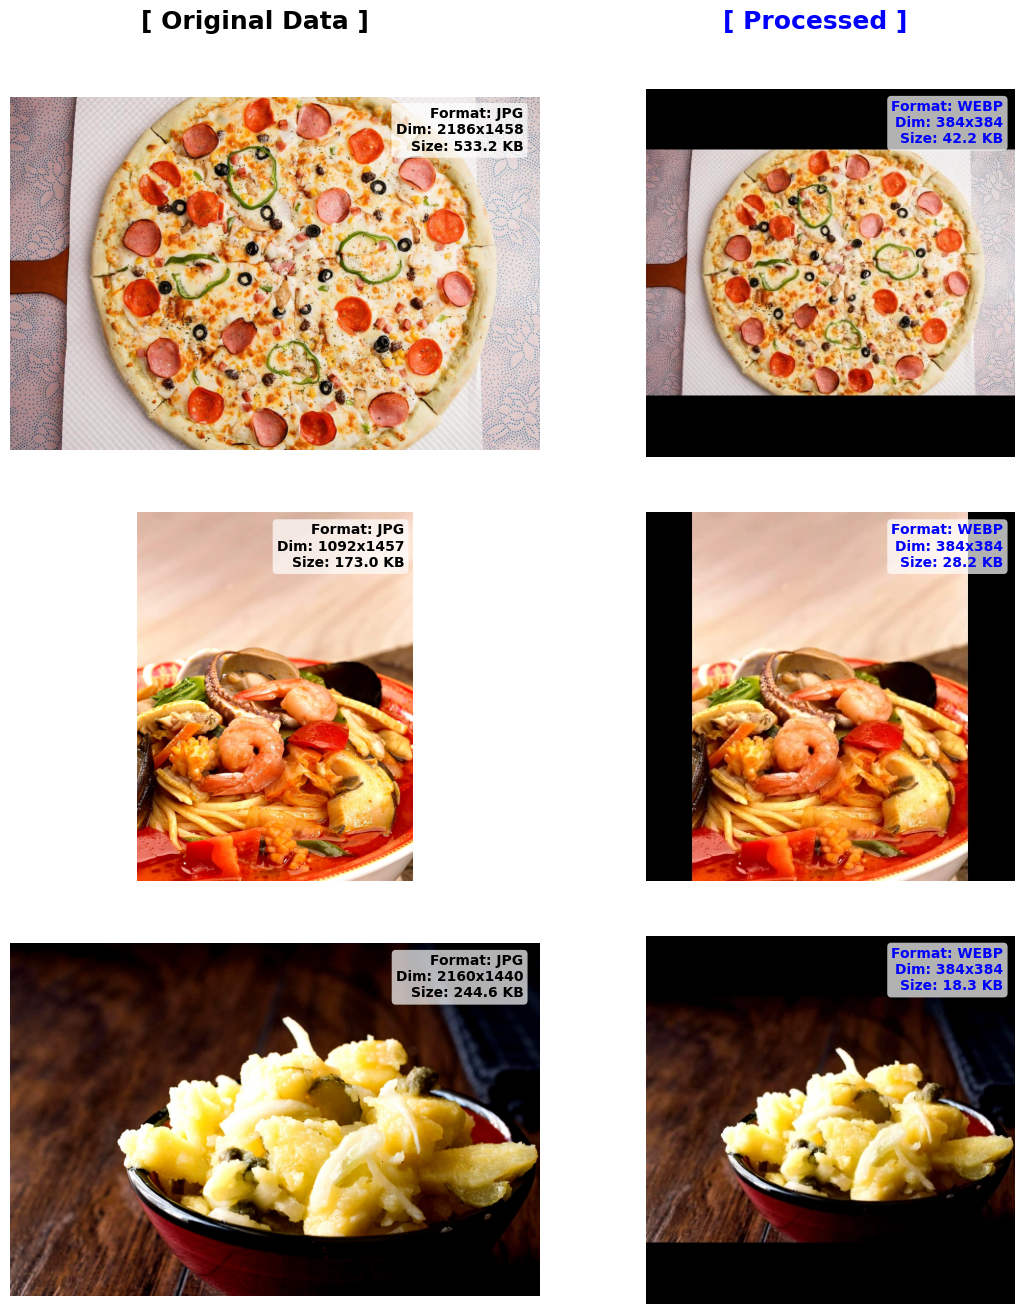

In [ ]:
# --- 시각화 리포트 ---
import cv2
import matplotlib.pyplot as plt
import random
import os
from pathlib import Path

def visualize_english_report(src_root, dst_root, num_samples=3):
    src_path = Path(src_root)
    dst_path = Path(dst_root)
    
    # Filter for image files
    valid_exts = ('.jpg', '.jpeg', '.png')
    all_origin_files = [f for f in src_path.rglob('*') if f.suffix.lower() in valid_exts]
    sample_files = random.sample(all_origin_files, min(num_samples, len(all_origin_files)))
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(14, 5 * num_samples))
    
    # Column Headers
    fig.text(0.3, 0.96, '[ Original Data ]', fontsize=18, fontweight='bold', ha='center')
    fig.text(0.7, 0.96, '[ Processed ]', fontsize=18, fontweight='bold', ha='center', color='blue')

    for i, origin_file in enumerate(sample_files):
        relative_path = origin_file.relative_to(src_path)
        processed_file = dst_path / relative_path.with_suffix('.webp')
        if not processed_file.exists(): continue

        # Load and convert BGR to RGB
        img_origin = cv2.cvtColor(cv2.imread(str(origin_file)), cv2.COLOR_BGR2RGB)
        img_processed = cv2.cvtColor(cv2.imread(str(processed_file)), cv2.COLOR_BGR2RGB)
        
        # Calculate sizes
        size_origin = os.path.getsize(origin_file) / 1024
        size_processed = os.path.getsize(processed_file) / 1024

        # Text and box styling
        text_style = dict(ha='right', va='top', fontsize=10, fontweight='bold', color='black')
        bbox_style = dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3')

        # --- Left: Original ---
        ax_org = axes[i, 0] if num_samples > 1 else axes[0]
        ax_org.imshow(img_origin)
        # Suffix only: .jpg -> JPG
        suffix_org = origin_file.suffix[1:].upper()
        info_org = f"Format: {suffix_org}\nDim: {img_origin.shape[1]}x{img_origin.shape[0]}\nSize: {size_origin:.1f} KB"
        
        ax_org.text(0.97, 0.97, info_org, transform=ax_org.transAxes, bbox=bbox_style, **text_style)
        ax_org.axis('off')

        # --- Right: Processed ---
        ax_proc = axes[i, 1] if num_samples > 1 else axes[1]
        ax_proc.imshow(img_processed)
        # Suffix is always WEBP for processed files
        info_proc = f"Format: WEBP\nDim: 384x384\nSize: {size_processed:.1f} KB"
        
        ax_proc.text(0.97, 0.97, info_proc, transform=ax_proc.transAxes, 
                     bbox=bbox_style, **{**text_style, 'color': 'blue'})
        ax_proc.axis('off')

    plt.subplots_adjust(top=0.92, hspace=0.15, wspace=0.05)
    plt.show()

# Execution
SRC = 'data/extracted'
DST = 'data/resized_384_webp'
visualize_english_report(SRC, DST, num_samples=3)